## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


def compute_points_for_calibration(images):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)

    return objpoints, imgpoints

## Apply a distortion correction to raw images.

In [2]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    warped = M = None

    if ret == True:
        # If we found corners, draw them! (just for fun)
        # cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)

        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [3]:
# Compute the camera calibration matrix and distortion coefficients

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
image_shape = cv2.imread(images[0]).shape[1::-1]
objpoints, imgpoints = compute_points_for_calibration(images)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
if not ret:
    print('Error')

### Calibration Test

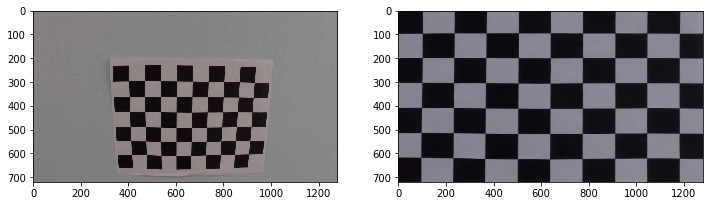

In [4]:
import matplotlib.image as mpimg
%matplotlib inline

nx, ny = 9, 6

cal_test_img = cv2.imread('./camera_cal/calibration17.jpg')
cal_warped, cal_M = corners_unwarp(cal_test_img, nx, ny, mtx, dist)
output_image_path = './output_images/cal_test.png'
cv2.imwrite(output_image_path, cal_warped)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(cal_test_img)
plt.subplot(1,2,2)
plt.imshow(mpimg.imread(output_image_path))

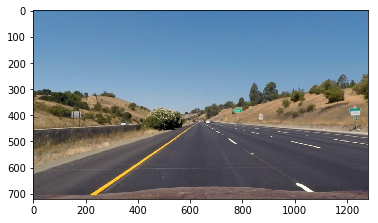

In [5]:
# straight
birds_eye_test_image = mpimg.imread('./test_images/straight_lines1.jpg')
undist_test = cv2.undistort(birds_eye_test_image, mtx, dist, None, mtx)
output_image_path = './output_images/undist_test.jpg'
cv2.imwrite(output_image_path, cv2.cvtColor(undist_test, cv2.COLOR_BGR2RGB))

plt.imshow(mpimg.imread(output_image_path))

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
def color_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Appy CLAHE algorithm to equalize contrast
    # clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    # gray = clahe.apply(gray)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

### Color Pipeline test

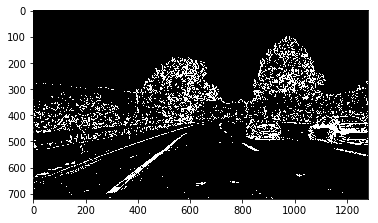

In [7]:
color_test_image = mpimg.imread('./test_images/test4.jpg')
undist_test = cv2.undistort(color_test_image, mtx, dist, None, mtx)
color_test_result = color_pipeline(undist_test)
plt.imshow(color_test_result, cmap='gray')

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
def get_image_src_dst(img):
    h, w = img.shape[0], img.shape[1]
    src = np.array([[w*0.445, h*0.627], [0, h], [w, h], [w*0.555, h*0.629]], dtype=np.float32)
    dst = np.array([[0, 0], [0, h], [w, h], [w, 0]], dtype=np.float32)
    return src, dst

def get_birds_eye_matrix(img):
    src, dst = get_image_src_dst(img)
    return cv2.getPerspectiveTransform(src, dst)

def get_birds_eye_inverse_matrix(img):
    src, dst = get_image_src_dst(img)
    return cv2.getPerspectiveTransform(dst, src)

def warper(img, src, dst):
    # Given src and dst points, calculate the perspective transform matrix
    M = get_birds_eye_matrix(img)
    # Warp the image using OpenCV warpPerspective()
    h, w = img.shape[0], img.shape[1]
    warped = cv2.warpPerspective(img, M, (w, h))
    return warped

def birds_eye_view(img):
    src, dst = get_image_src_dst(img)
    return warper(img, src, dst)

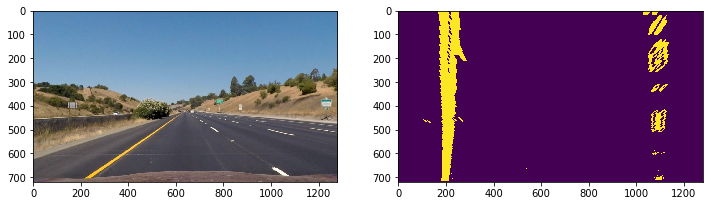

In [9]:
# straight
birds_eye_test_image = mpimg.imread('./test_images/straight_lines1.jpg')
undist_test = cv2.undistort(birds_eye_test_image, mtx, dist, None, mtx)
birds_eye_test_result = color_pipeline(undist_test)
birds_eye_trans_img = birds_eye_view(birds_eye_test_result)

output_image_path = './output_images/birds_eye_test.jpg'
cv2.imwrite(output_image_path, birds_eye_trans_img*255)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(undist_test)
plt.subplot(1,2,2)
plt.imshow(mpimg.imread(output_image_path))
plt.imshow(mpimg.imread(output_image_path))

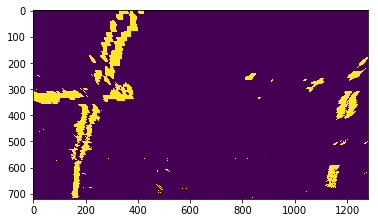

In [10]:
# curve
birds_eye_test_curve = mpimg.imread('./test_images/test5.jpg')
undist_test = cv2.undistort(birds_eye_test_curve, mtx, dist, None, mtx)
birds_eye_test_curve_result = color_pipeline(undist_test)
birds_eye_trans_curve = birds_eye_view(birds_eye_test_curve_result)

output_image_path = './output_images/birds_eye_curve.jpg'
cv2.imwrite(output_image_path, birds_eye_trans_curve*255)

plt.imshow(mpimg.imread(output_image_path))

## Detect lane pixels and fit to find the lane boundary.

In [11]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit_x = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    left_lane_inds = ((nonzerox > left_fit_x - margin)
                    & (nonzerox < left_fit_x + margin))
    right_fix_x = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > right_fix_x - margin)
                    & (nonzerox < right_fix_x + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, 

In [12]:
def find_lane_pixels(binary_warped, visualize=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if (visualize):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, visualize=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, visualize)
    left_fitx, right_fitx, ploty, _, _ = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    if (not visualize):
        return out_img

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

### Find lanes test

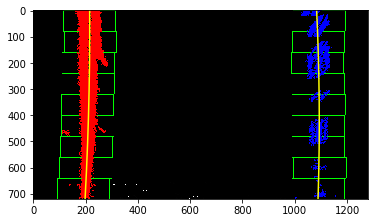

In [13]:
# straight
# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('./output_images/birds_eye_test.jpg')

# Polynomial fit values from the previous frame
result_ = fit_polynomial(binary_warped, True)

# View your output
cv2.imwrite('./output_images/find_lane_test_straight.jpg', cv2.cvtColor(result_, cv2.COLOR_BGR2RGB))
plt.imshow(result_)

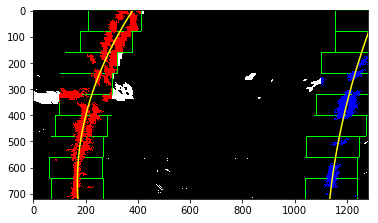

In [34]:
# curve
# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('./output_images/birds_eye_curve.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

result_ = fit_polynomial(binary_warped, True)
#result_ = search_around_poly(binary_warped//255)

# View your output
cv2.imwrite('./output_images/find_lane_test_curve.jpg', cv2.cvtColor(result_, cv2.COLOR_BGR2RGB))
plt.imshow(result_)

## Determine the curvature of the lane and vehicle position with respect to center.

In [15]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature_real(left_fit_cr, right_fit_cr, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def vehicle_position_real(img, left_fit_cr, right_fit_cr, ploty):
    y_eval = np.max(ploty) * ym_per_pix
    left_base = left_fit_cr[0] * y_eval**2 + left_fit_cr[1] * y_eval + left_fit_cr[2]
    right_base = right_fit_cr[0] * y_eval**2 + right_fit_cr[1] * y_eval + right_fit_cr[2]
    center_cr = xm_per_pix * img.shape[1] / 2
    return center_cr - (left_base + right_base) / 2

### Curvature Test

337.6239287983901 m 834.0671638386332 m


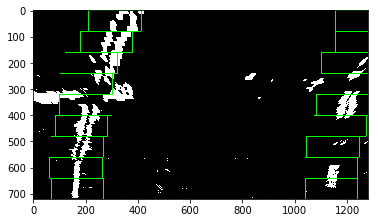

In [16]:
binary_warped = mpimg.imread('./output_images/birds_eye_curve.jpg')
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, True)
plt.imshow(out_img)
# Define conversions in x and y from pixels space to meters
left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_curverad, right_curverad = measure_curvature_real(left_fit_cr, right_fit_cr, ploty)
print(left_curverad, 'm', right_curverad, 'm')

## Warp the detected lane boundaries back onto the original image.

In [17]:
def back_projection(undist, warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

### Test

-0.06489937736821849


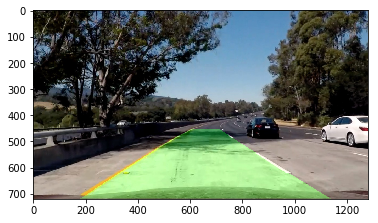

In [18]:
# birds_eye_test_curve = mpimg.imread('./test_images/test5.jpg')
birds_eye_test_curve = mpimg.imread('./test_images/test5.jpg')
undist_test = cv2.undistort(birds_eye_test_curve, mtx, dist, None, mtx)
binary_warped = mpimg.imread('./output_images/birds_eye_curve.jpg')
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
left_fitx, right_fitx, ploty, _, _ = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
Minv = get_birds_eye_inverse_matrix(binary_warped)
back_image = back_projection(undist_test, binary_warped, left_fitx, right_fitx, ploty, Minv)
plt.imshow(back_image)

# vehicle position
left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
cv2.imwrite('./output_images/warp_test.jpg', cv2.cvtColor(back_image, cv2.COLOR_BGR2RGB))
print(vehicle_position_real(back_image, left_fit_cr, right_fit_cr, ploty))

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
from collections import deque
recent_left_fitx = deque([], 20)
recent_right_fitx = deque([], 20)
recent_radius = deque([], 20)

def init_pipeline():
    global recent_left_fitx
    global recent_right_fitx
    global recent_radius
    recent_left_fitx = deque([], 20)
    recent_right_fitx = deque([], 20)
    recent_radius = deque([], 20)

def pipeline(img):
    # Apply a distortion correction to raw images.
    # Make sure mtx and dist are calculated
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Use color transforms, gradients, etc., to create a thresholded binary image.
    color_result = color_pipeline(undist)

    # Apply a perspective transform to rectify binary image ("birds-eye view").
    birds_eye = birds_eye_view(color_result)

    # Detect lane pixels and fit to find the lane boundary.
    leftx, lefty, rightx, righty, _ = find_lane_pixels(birds_eye, False)
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(birds_eye.shape, leftx, lefty, rightx, righty)
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad, right_curverad = measure_curvature_real(left_fit_cr, right_fit_cr, ploty)

    # Smoothing
    recent_left_fitx.append(left_fitx)
    recent_right_fitx.append(right_fitx)
    recent_radius.append((left_curverad + right_curverad)//2)
    avg_left_fitx = np.mean(recent_left_fitx, axis=0)
    avg_right_fitx = np.mean(recent_right_fitx, axis=0)
    avg_radius = np.mean(recent_radius, axis=0)
    
    # Warp the detected lane boundaries back onto the original image.
    Minv = get_birds_eye_inverse_matrix(undist)
    back_image = back_projection(undist, birds_eye, avg_left_fitx, avg_right_fitx, ploty, Minv)

    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    curv_text = 'Radius of Curvature = {}(m)'.format(int(avg_radius))
    vehicle_pos = round(vehicle_position_real(back_image, left_fit_cr, right_fit_cr, ploty), 2)
    if vehicle_pos >= 0:
        vehicle_text = 'Vehicle is {}m left of center'.format(vehicle_pos)
    else:
        vehicle_text = 'Vehicle is {}m right of center'.format(-vehicle_pos)
    cv2.putText(back_image, curv_text, (0, 50), cv2.FONT_HERSHEY_PLAIN, 4, (255, 255, 255), 5, cv2.LINE_AA)
    cv2.putText(back_image, vehicle_text, (0, 100), cv2.FONT_HERSHEY_PLAIN, 4, (255, 255, 255), 5, cv2.LINE_AA)

    return back_image

### Pipeline Test

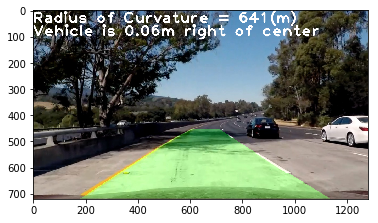

In [21]:
pipeline_test = mpimg.imread('./test_images/test5.jpg')
init_pipeline()
result_ = pipeline(pipeline_test)
cv2.imwrite('./output_images/pipeline_test.jpg', cv2.cvtColor(result_, cv2.COLOR_BGR2RGB))
plt.imshow(result_)

### project_video

In [22]:
init_pipeline()
project_video = VideoFileClip("./project_video.mp4")
project_clip = project_video.fl_image(pipeline)
project_output = './output_images/project_video_output.mp4'
%time project_clip.write_videofile(project_output, audio=False, logger=None)

Wall time: 1min 27s


### challenge_video

In [23]:
init_pipeline()
challenge_video = VideoFileClip("./challenge_video.mp4")
challenge_clip = challenge_video.fl_image(pipeline)
challenge_output = './output_images/challenge_video_output.mp4'
%time challenge_clip.write_videofile(challenge_output, audio=False, logger=None)

Wall time: 30 s


### harder_challenge_video

In [24]:
init_pipeline()
harder_video = VideoFileClip("./harder_challenge_video.mp4")
harder_clip = harder_video.fl_image(pipeline)
harder_output = './output_images/harder_video_output.mp4'
%time harder_clip.write_videofile(harder_output, audio=False, logger=None)

Wall time: 1min 33s
